In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

## Data Preperation

In [ ]:
# ! cp drive/MyDrive/Data/raw_swa.npz ./

In [ ]:
raw = np.load('raw_swa.npz')
y = raw['label']
X = raw['raw_recording']
X = X[1]

num_sequences = len(X) // 2000
X = X[:num_sequences * 2000].reshape(num_sequences, 2000)
y = y[:num_sequences]

## Model 1: ConvNet

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
class ConvNetData(Dataset):
    def __init__(self, X, y):
        self.recording = torch.tensor(X).float()
        self.recording = self.recording.unsqueeze(1)
        self.labels = torch.tensor(y).long()

    def __len__(self):
        return self.recording.shape[0]

    def __getitem__(self, idx):
        return self.recording[idx], self.labels[idx]

def to_tensor(batch):
    X = torch.stack([batch[i][0] for i in range(len(batch))])
    y = torch.stack([batch[i][1] for i in range(len(batch))])

    return X, y

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.encode = nn.Sequential(
            nn.Conv1d(1, 16, 5),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, 5),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 5),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
        )

        self.label_head = nn.Sequential(
            nn.Linear(64 * 246, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(128, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, 3),
        )

    def forward(self, x):
        x = self.encode(x)
        x = x.flatten(start_dim=1)
        x = self.label_head(x)
        return x

In [ ]:
data_train = ConvNetData(X_train, y_train)
data_test = ConvNetData(X_test, y_test)
loader_train = DataLoader(data_train, batch_size=64, collate_fn=to_tensor)

In [ ]:
# Training

model = ConvNet()
criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.005, 0.005, 5]).to(0))
optimizer = optim.Adam(model.parameters(), lr=1e-4)
epochs = 100

model.to(0)
count = 0
for epoch in range(epochs):
    model.train()
    for X, y in loader_train:
        count += 1
        optimizer.zero_grad()
        output = model(X.to(0))
        loss = criterion(output, y.to(0))
        loss.backward()
        optimizer.step()

        # if count % 100 == 0:
        #     print(f'Loss: {loss.item()}')

In [ ]:
# Test

loader_test = DataLoader(data_test, batch_size=1, collate_fn=to_tensor)
model.eval()

true_labels = []
pred_labels = []
for X, y in loader_test:
    output = model(X.to(0))
    pred = output.argmax(dim=1).item()
    true = y.item()
    pred_labels.append(pred)
    true_labels.append(true)

Accuracy: 0.8231481481481482


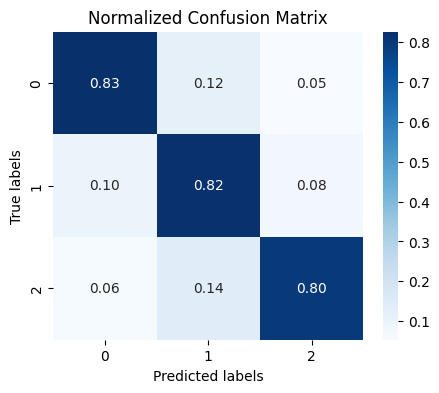

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Normalization can be applied by setting 'normalize=True'
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Calculate accuracy and other metrics
accuracy = accuracy_score(true_labels, pred_labels)

print(f'Accuracy: {accuracy}')

# Plotting the confusion matrix using seaborn
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(cm_normalized, annot=True, ax=ax, cmap='Blues', fmt='.2f')

# Labels, title and ticks
label_classes = np.unique(true_labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Normalized Confusion Matrix')
ax.xaxis.set_ticklabels(label_classes)
ax.yaxis.set_ticklabels(label_classes)
plt.show()

In [ ]:
from torchsummary import summary
summary(model, (1, 2000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 16, 1996]              96
       BatchNorm1d-2             [-1, 16, 1996]              32
         LeakyReLU-3             [-1, 16, 1996]               0
         MaxPool1d-4              [-1, 16, 998]               0
            Conv1d-5              [-1, 32, 994]           2,592
       BatchNorm1d-6              [-1, 32, 994]              64
         LeakyReLU-7              [-1, 32, 994]               0
         MaxPool1d-8              [-1, 32, 497]               0
            Conv1d-9              [-1, 64, 493]          10,304
      BatchNorm1d-10              [-1, 64, 493]             128
        LeakyReLU-11              [-1, 64, 493]               0
        MaxPool1d-12              [-1, 64, 246]               0
           Linear-13                  [-1, 128]       2,015,360
      BatchNorm1d-14                  [

In [ ]:
raw = np.load('raw_swa.npz')
y = raw['label']
X = raw['raw_recording']
X = X[1]

num_sequences = len(X) // 2000
X = X[:num_sequences * 2000].reshape(num_sequences, 2000)
y = y[:num_sequences]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
data_test = ConvNetData(X_test, y_test)
loader_test = DataLoader(data_test, batch_size=1, collate_fn=to_tensor)
model.eval()

true_labels = []
pred_labels = []
for X, y in loader_test:
    output = model(X.to(0))
    pred = output.argmax(dim=1).item()
    true = y.item()
    pred_labels.append(pred)
    true_labels.append(true)

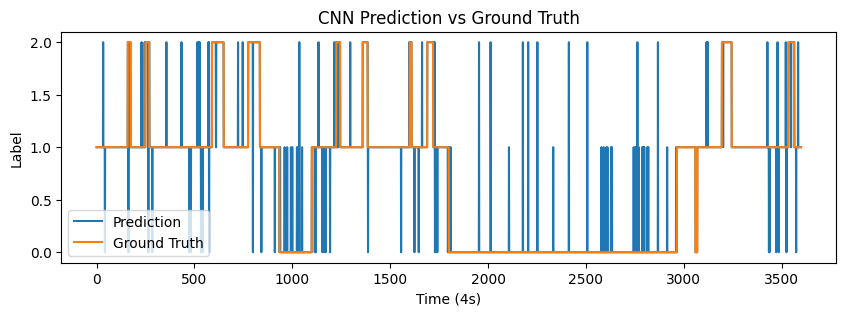

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 3))

axs.plot(range(3600), pred_labels[:3600])
axs.plot(range(3600), true_labels[:3600])
axs.legend(["Prediction", "Ground Truth"])
axs.set_xlabel("Time (4s)")
axs.set_ylabel("Label")
axs.set_title("CNN Prediction vs Ground Truth")
plt.show()

## Model 2: Transformer

In [ ]:
seq_len = 30
raw = np.load('raw_swa.npz')
y = raw['label']
X = raw['raw_recording']
X = X[1]

In [ ]:
num_sequences = len(X) // (2000 * seq_len)
X = X[:num_sequences * 2000 * seq_len].reshape(num_sequences, -1)
y = y[:num_sequences * seq_len].reshape(-1, seq_len)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
class TData(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
class AttenNet(nn.Module):
    def __init__(self, hidden_size, num_classes, classifier, num_layers=4):
        super(AttenNet, self).__init__()

        self.seq_embedding = classifier

        self.upsample = nn.Linear(3, hidden_size)

        self.positional_embedding = nn.Parameter(torch.randn(seq_len, hidden_size) / hidden_size ** 0.5)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size,
            nhead=4,
            dim_feedforward=hidden_size * 4,
            activation=nn.GELU(),
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        logit = []
        for i in range(x.size(1)):
            logit.append(self.seq_embedding(x[:, [i]]))
        x = torch.stack(logit, dim=1)
        #x = F.softmax(x, dim=-1)
        x = self.upsample(x)
        x = x.view(x.size(0), seq_len, -1)
        x = x + self.positional_embedding[: seq_len].unsqueeze(0)
        x = self.transformer(
            x
        )
        x = self.classifier(x)
        return x

In [ ]:
data_train = TData(X_train, y_train)
loader_train = DataLoader(data_train, batch_size=32)
data_test = TData(X_test, y_test)
loader_test = DataLoader(data_test, batch_size=1)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiClassDiceLoss1D(nn.Module):
    def __init__(self, weights=None, ignore_index=None, smooth=1.0):
        super(MultiClassDiceLoss1D, self).__init__()
        self.weights = weights
        self.ignore_index = ignore_index
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Assuming that inputs are logits
        inputs = F.softmax(inputs, dim=1)

        # Create the one-hot encoding of targets
        targets_one_hot = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 2, 1).float()

        # Apply weights if provided
        if self.weights is not None:
            weights = torch.tensor(self.weights).float().to(inputs.device)
        else:
            weights = torch.ones(inputs.shape[1]).float().to(inputs.device)

        # Calculate Dice coefficient for each class and then average
        total_loss = 0
        for class_idx in range(inputs.shape[1]):
            if self.ignore_index is not None and class_idx == self.ignore_index:
                continue
            intersect = (inputs[:, class_idx] * targets_one_hot[:, class_idx]).sum()
            denominator = inputs[:, class_idx].sum() + targets_one_hot[:, class_idx].sum()

            # Dice score for this class
            dice_score = (2. * intersect + self.smooth) / (denominator + self.smooth)
            class_loss = 1 - dice_score

            # Weighted loss for this class
            total_loss += class_loss * weights[class_idx]

        return total_loss / weights.sum()

dice = MultiClassDiceLoss1D([0.5, 0.2, 1])

In [ ]:
# Training

model_atten = AttenNet(hidden_size=128, num_classes=3, classifier=model)
criterion = nn.CrossEntropyLoss()
model_atten.seq_embedding.requires_grad_(False)
optimizer = optim.Adam([p for p in model_atten.parameters() if p.requires_grad], lr=1e-5)
epochs = 100


model_atten.to(0)
count = 0
for epoch in range(epochs):
    for X, y in loader_train:
        count += 1
        optimizer.zero_grad()
        output = model_atten(X.view(32, 30, -1).to(0))
        output = output.permute(0, 2, 1)
        loss = criterion(output, y.to(0))
        loss.backward()
        optimizer.step()

        if count % 100 == 0:
            print(f'Loss: {loss.item()}')

Loss: 0.09826754033565521
Loss: 0.038660693913698196
Loss: 0.01818651705980301
Loss: 0.04039350897073746
Loss: 0.04179464653134346
Loss: 0.03872799873352051
Loss: 0.04294448718428612
Loss: 0.02583996020257473
Loss: 0.013153632171452045
Loss: 0.03303294628858566
Loss: 0.010644180700182915
Loss: 0.005368584301322699
Loss: 0.028092224150896072
Loss: 0.034856490790843964
Loss: 0.026948977261781693
Loss: 0.028141537681221962
Loss: 0.020453447476029396
Loss: 0.00895086769014597


In [ ]:
# Test

model.eval()

true_labels = []
pred_labels = []
for X, y in loader_test:
    output = model_atten(X.view(1, 30, -1).to(0))
    pred = output.argmax(dim=-1).squeeze(0)
    true = y.squeeze(0)
    pred_labels.append(pred)
    true_labels.append(true)

true_labels = torch.cat(true_labels).cpu().numpy()
pred_labels = torch.cat(pred_labels).cpu().numpy()

Accuracy: 0.9868055555555556


[Text(0, 0.5, '0'), Text(0, 1.5, '1'), Text(0, 2.5, '2')]

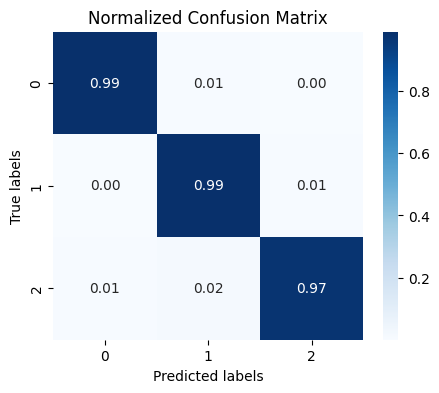

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Normalization can be applied by setting 'normalize=True'
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Calculate accuracy and other metrics
accuracy = accuracy_score(true_labels, pred_labels)

print(f'Accuracy: {accuracy}')

# Plotting the confusion matrix using seaborn
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(cm_normalized, annot=True, ax=ax, cmap='Blues', fmt='.2f')

# Labels, title and ticks
label_classes = np.unique(true_labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Normalized Confusion Matrix')
ax.xaxis.set_ticklabels(label_classes)
ax.yaxis.set_ticklabels(label_classes)

In [ ]:
model_atten

AttenNet(
  (seq_embedding): ConvNet(
    (encode): Sequential(
      (0): Conv1d(1, 16, kernel_size=(5,), stride=(1,))
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv1d(16, 32, kernel_size=(5,), stride=(1,))
      (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv1d(32, 64, kernel_size=(5,), stride=(1,))
      (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.01)
      (11): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (label_head): Sequential(
      (0): Linear(in_features=15744, out_features=128, bias=True)
     

In [ ]:
seq_len = 30
raw = np.load('raw_swa.npz')
y = raw['label']
X = raw['raw_recording']
X = X[1]

num_sequences = len(X) // (2000 * seq_len)
X = X[:num_sequences * 2000 * seq_len].reshape(num_sequences, -1)
y = y[:num_sequences * seq_len].reshape(-1, seq_len)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
data_test = TData(X_test, y_test)
loader_test = DataLoader(data_test, batch_size=1)

model_atten.eval()

true_labels = []
pred_labels = []
for X, y in loader_test:
    output = model_atten(X.view(1, 30, -1).to(0))
    pred = output.argmax(dim=-1).squeeze(0)
    true = y.squeeze(0)
    pred_labels.append(pred)
    true_labels.append(true)

true_labels = torch.cat(true_labels).cpu().numpy()
pred_labels = torch.cat(pred_labels).cpu().numpy()

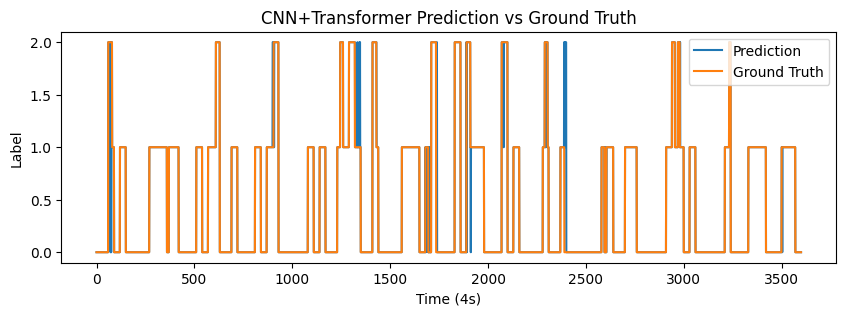

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 3))

axs.plot(range(3600), pred_labels[:3600])
axs.plot(range(3600), true_labels[:3600])
axs.legend(["Prediction", "Ground Truth"])
axs.set_xlabel("Time (4s)")
axs.set_ylabel("Label")
axs.set_title("CNN+Transformer Prediction vs Ground Truth")
plt.show()

## Model 3

In [ ]:
seq_len = 30
raw = np.load('raw_swa.npz')
y = raw['label']
X = raw['raw_recording']
X = X[1]

In [ ]:
num_sequences = len(X) // (2000 * seq_len)
X = X[:num_sequences * 2000 * seq_len].reshape(num_sequences, -1)
y = y[:num_sequences * seq_len].reshape(-1, seq_len)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = normalize(X_train)
X_test = normalize(X_test)

In [ ]:
class TData(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
class MAE(nn.Module):
    def __init__(self, hidden_size=256):
        super(MAE, self).__init__()

        self.seq_embedding = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=125, stride=125),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Conv1d(64, hidden_size, kernel_size=16, stride=16),
            nn.BatchNorm1d(hidden_size),
            nn.LeakyReLU(),
        )
        self.positional_embedding = nn.Parameter(torch.randn(seq_len, hidden_size) / hidden_size ** 0.5)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size,
            nhead=4,
            dim_feedforward=hidden_size * 4,
            activation=nn.GELU(),
            batch_first=True
        )

        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.decoder = nn.TransformerEncoder(encoder_layer, num_layers=2)

        self.reconstruct = nn.Sequential(
            nn.ConvTranspose1d(256, 64, kernel_size=16, stride=16),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(64, 1, kernel_size=125, stride=125)
        )

    def encode(self, x, mask):
        x = self.seq_embedding(x)
        x = x.view(x.size(0), x.size(-1), -1)
        x = x + self.positional_embedding
        x = self.encoder(x, mask=mask)

        return x

    def decode(self, x):
        x = self.decoder(x)
        x = x.view(x.size(0), x.size(-1), -1)
        x = self.reconstruct(x)

        return x


    def forward(self, x, mask):
        x = self.encode(x, mask)
        x = self.decode(x)
        return x

class MAE_classifier(nn.Module):
    def __init__(self, encoder):
        super(MAE_classifier, self).__init__()

        self.encoder = encoder

        self.classifier = nn.Sequential(
            nn.Linear(7680, 1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 3)
        )

    def forward(self, x):
        x = self.encoder.encode(x, None)
        x = x.flatten(start_dim=1)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

In [ ]:
import torch
import numpy as np

def generate_mask(seq_length, pad_ratio):
    """
    Generates a random attention mask for use with PyTorch's transformers where some positions are masked.

    Args:
    seq_length (int): The length of the sequence.
    pad_ratio (float): The fraction of the sequence that is to be masked.

    Returns:
    torch.Tensor: An attention mask where 0 indicates "not masked" and -inf indicates "masked".
    """
    line_mask = torch.rand(seq_length) >= pad_ratio
    mask = line_mask.unsqueeze(0).repeat(seq_length, 1).float()  # Repeat the line mask across all rows
    mask[mask == 0] = -float('inf')  # Set masked positions to -inf
    mask[mask == 1] = 0  # Set unmasked positions to 0
    return mask


In [ ]:
data_train = TData(X_train, y_train)
loader_train = DataLoader(data_train, batch_size=32)
data_test = TData(X_test, y_test)
loader_test = DataLoader(data_test, batch_size=1)

In [ ]:
# Train encoder

model = MAE(hidden_size=256)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
epochs = 100

model.to(0)
count = 0
for epoch in range(epochs):
    for X, y in loader_train:
        count += 1
        optimizer.zero_grad()
        mask = generate_mask(30, 0.8)
        output = model(X.to(0), mask.to(0))
        loss = criterion(output, X.to(0))
        loss.backward()
        optimizer.step()

        if count % 100 == 0:
            print(f'Loss: {loss.item()}')

Loss: 0.0034736173693090677
Loss: 0.0012609736295416951
Loss: 0.0008332383586093783
Loss: 0.0005630284431390464
Loss: nan
Loss: nan


KeyboardInterrupt: 

> /usr/local/lib/python3.10/dist-packages/torch/autograd/__init__.py(266)backward()
    264     # some Python versions print out the first line of a multi-line function
    265     # calls in the traceback and some print out the last line
--> 266     Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
    267         tensors,
    268         grad_tensors_,

ipdb> exit


In [ ]:
# Train classifier

model_classifier = MAE_classifier(model).to(0)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
epochs = 100

model.to(0)
count = 0
for epoch in range(epochs):
    for X, y in loader_train:
        count += 1
        optimizer.zero_grad()
        output = model_classifier(X.to(0))
        loss = criterion(output, y.to(0))
        loss.backward()
        optimizer.step()

        if count % 100 == 0:
            print(f'Loss: {loss.item()}')

In [ ]:
%pdb

Automatic pdb calling has been turned ON


### Model 4

In [ ]:
raw = np.load('raw_swa.npz')
y = raw['label']
X = raw['raw_recording']
X = X[1]

num_sequences = len(X) // 2000
X = X[:num_sequences * 2000].reshape(num_sequences, 2000)
y = y[:num_sequences]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

X_train = normalize(X_train)
X_test = normalize(X_test)

In [ ]:
class ConvNetData(Dataset):
    def __init__(self, X, y):
        self.recording = torch.tensor(X).float()
        self.recording = self.recording.unsqueeze(1)
        self.labels = torch.tensor(y).long()

    def __len__(self):
        return self.recording.shape[0]

    def __getitem__(self, idx):
        return self.recording[idx], self.labels[idx]

def to_tensor(batch):
    X = torch.stack([batch[i][0] for i in range(len(batch))])
    y = torch.stack([batch[i][1] for i in range(len(batch))])

    return X, y

In [ ]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, stride=2, padding=1),  # output: 16 x 1000
            nn.LeakyReLU(),
            nn.Conv1d(16, 32, kernel_size=3, stride=2, padding=1),  # output: 32 x 500
            nn.LeakyReLU(),
            nn.Conv1d(32, 64, kernel_size=3, stride=2, padding=1),  # output: 64 x 250
            nn.LeakyReLU(),
            nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1),  # output: 128 x 125
            nn.LeakyReLU(),
        )
        self.encoded_space_dim = 128 * 125

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(
                128, 64, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(
                64, 32, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(
                32, 16, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(
                16, 1, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            # No activation here, as we're outputting raw signal values
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded.squeeze(1)  # Remove channel dimension for output


class ClassDecoder(nn.Module):
    def __init__(self, encoder) -> None:
        super().__init__()
        self.encoder = encoder
        self.net = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(self.encoder.encoded_space_dim, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 3),
        )

    def forward(self, x):
        encoded = self.encoder.encoder(x)
        return self.net(encoded)

In [ ]:
data_train = ConvNetData(X_train, y_train)
data_test = ConvNetData(X_test, y_test)
loader_train = DataLoader(data_train, batch_size=64, collate_fn=to_tensor)
loader_test = DataLoader(data_test, batch_size=1, collate_fn=to_tensor)

In [ ]:
# Training

model = ConvAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
epochs = 100

model.to(0)
count = 0
for epoch in range(epochs):
    for X, y in loader_train:
        count += 1
        optimizer.zero_grad()
        output = model(X.to(0))
        loss = criterion(output, X.to(0))
        loss.backward()
        optimizer.step()

        if count % 100 == 0:
            print(f'Loss: {loss.item()}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 2000])) that is different to the input size (torch.Size([64, 2000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.20412683486938477
Loss: 0.18424446880817413
Loss: 0.16183722019195557
Loss: 0.13171625137329102
Loss: 0.09269954264163971
Loss: 0.06113887205719948
Loss: 0.03347236290574074
Loss: 0.013213444501161575
Loss: 0.006288069300353527
Loss: 0.003666148753836751
Loss: 0.002358603524044156
Loss: 0.00167232402600348
Loss: 0.0013081011129543185
Loss: 0.001083700335584581
Loss: 0.0009232605225406587
Loss: 0.0008005838026292622
Loss: 0.0007408583769574761
Loss: 0.0006605242961086333
Loss: 0.0005919139948673546
Loss: 0.0005712519050575793
Loss: 0.0005408964352682233
Loss: 0.000555620645172894
Loss: 0.0004972817841917276
Loss: 0.0005064144497737288
Loss: 0.00046694802585989237
Loss: 0.00048784303362481296
Loss: 0.0004788295191247016
Loss: 0.00047718299902044237
Loss: 0.00045435692300088704
Loss: 0.0004594447964336723
Loss: 0.00046691103489138186
Loss: 0.00047527565038762987
Loss: 0.00046726124128326774
Loss: 0.0004655416705645621
Loss: 0.00045210577081888914
Loss: 0.00048259057803079486
Loss:

In [ ]:
# Training

modelc = ClassDecoder(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelc.parameters(), lr=1e-4)
epochs = 100

modelc.encoder.requires_grad_(False)

modelc.to(0)
count = 0
for epoch in range(epochs):
    for X, y in loader_train:
        count += 1
        optimizer.zero_grad()
        output = modelc(X.to(0))
        loss = criterion(output, y.to(0))
        loss.backward()
        optimizer.step()

        if count % 100 == 0:
            print(f'Loss: {loss.item()}')

Loss: 0.9021228551864624
Loss: 0.7487620711326599
Loss: 0.8229913711547852
Loss: 0.8992913961410522
Loss: 0.8094643950462341
Loss: 0.8107115030288696
Loss: 0.8372943997383118
Loss: 0.7856268286705017
Loss: 0.7699785828590393
Loss: 0.8195868134498596
Loss: 0.7755548357963562
Loss: 0.7342227697372437
Loss: 0.8354368209838867
Loss: 0.8494749665260315
Loss: 0.9187442064285278
Loss: 0.87070232629776
Loss: 0.8223105669021606
Loss: 0.8439832925796509
Loss: 0.8063613772392273
Loss: 0.9404482245445251
Loss: 0.7867977023124695
Loss: 0.8144316673278809
Loss: 0.9208201169967651
Loss: 0.8420205116271973
Loss: 0.8722758293151855
Loss: 0.7775053977966309
Loss: 0.880866527557373
Loss: 0.8970090746879578
Loss: 0.7451882362365723
Loss: 0.8210863471031189
Loss: 0.903634786605835
Loss: 0.8168431520462036
Loss: 0.8054835200309753
Loss: 0.8370175361633301
Loss: 0.7972474098205566
Loss: 0.763702929019928
Loss: 0.8156575560569763
Loss: 0.7787026166915894
Loss: 0.7358589768409729
Loss: 0.8403459787368774
Loss:

In [ ]:
# Test

loader_test = DataLoader(data_test, batch_size=1, collate_fn=to_tensor)
modelc.eval()

true_labels = []
pred_labels = []
for X, y in loader_test:
    output = modelc(X.to(0))
    pred = output.argmax(dim=1).item()
    true = y.item()
    pred_labels.append(pred)
    true_labels.append(true)

Accuracy: 0.5879629629629629


[Text(0, 0.5, '0'), Text(0, 1.5, '1'), Text(0, 2.5, '2')]

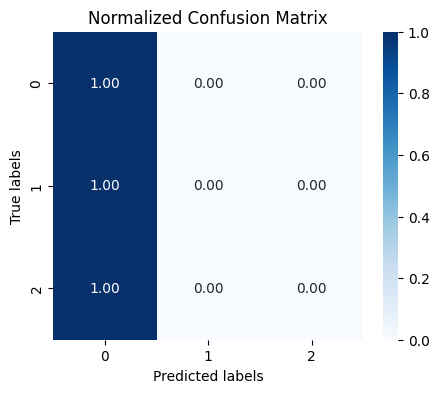

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Normalization can be applied by setting 'normalize=True'
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Calculate accuracy and other metrics
accuracy = accuracy_score(true_labels, pred_labels)

print(f'Accuracy: {accuracy}')

# Plotting the confusion matrix using seaborn
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(cm_normalized, annot=True, ax=ax, cmap='Blues', fmt='.2f')

# Labels, title and ticks
label_classes = np.unique(true_labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Normalized Confusion Matrix')
ax.xaxis.set_ticklabels(label_classes)
ax.yaxis.set_ticklabels(label_classes)

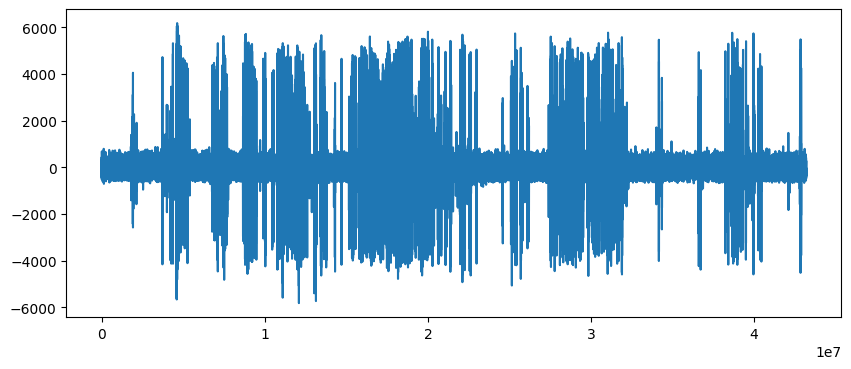

In [ ]:
raw = np.load('raw_swa.npz')
y = raw['label']
X = raw['raw_recording']
X = X[1]

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(range(len(X)), X)